# NLP - Limpeza de datos de comentarios imdb

### Proximos pasos:
* Normalizar pronombres: Reemplazar entidades que refieran a personas por MALE y FEMALE (personajes, actores y pronombres) --> https://www.researchgate.net/profile/Edgar_Altszyler/publication/331304421_Half_a_Century_of_Stereotyping_Associations_Between_Gender_and_Intellectual_Ability_in_Films/links/5cbcbb064585156cd7a8c3a5/Half-a-Century-of-Stereotyping-Associations-Between-Gender-and-Intellectual-Ability-in-Films.pdf
* Name Entity Recognition --> https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/NLP%20Strategy%20I%20-%20Processing%20and%20Understanding%20Text.ipynb
* Sentiment analysis --> Text blob: https://textblob.readthedocs.io/en/dev/quickstart.html
* Empezar corriendo un NAIVE BAYES sin hacer ninguna variable a ver como da la prediccion. Eso nos va a dar un piso. https://textblob.readthedocs.io/en/dev/classifiers.html#classifiers



In [ ]:
# Importo librerias
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#import nltk
#nltk.download('stopwords')
# ! pip install gensim
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser
#! pip install normalise
#for dependency in ("brown", "names", "wordnet", "averaged_perceptron_tagger", "universal_tagset"):
#    nltk.download(dependency)
from normalise import normalise
#! pip install textblob
from textblob import TextBlob
#! pip install emoji
import emoji
# imports
import unicodedata

In [ ]:
#Cargo el dataset que contiene las reviews
df = pd.read_csv('C:/Users/tomas/Desktop/Maestria Data Mining/Text Mining/imdb_reviews.csv')
df.head()

,Unnamed: 0,imdbid,rev_title,rev_content,rating,rev_link,rev_username,rev_date
0,0,tt3907584,A spectacular movie\n,"The first act felt annoyingly pretentious, how...",9,/review/rw5556178/,MR_Heraclius,16 March 2020
1,1,tt3907584,so....read this up.\n,I did not know this was made after a book. I d...,9,/review/rw5515902/,suciulaurentiucristian,28 February 2020
2,2,tt3907584,they had so much but they gave too little\n,I had this feeling since they announced the mo...,5,/review/rw5515384/,mermariam,28 February 2020
3,3,tt3907584,People who call him selfish have never experi...,I saw some negative reviews not getting the lo...,10,/review/rw5525473/,viktoriabr-21711,4 March 2020
4,4,tt3907584,Beautiful movie.\n,Randomly found this movie today and I only hav...,10,/review/rw5516559/,aeo-90520,29 February 2020


### Poner la fecha en formato YYYYMMDD

In [ ]:
from dateutil import parser
df['rev_date']=df['rev_date'].apply(lambda x: parser.parse(x).strftime('%Y%m%d'))

### Creo 'df_prueba' (df reducido a 50 reviews) para hacer pruebas de forma mas comoda

In [ ]:
# Creo df de prueba
df_prueba = df.loc[0:50,:]
df_prueba.head()

,Unnamed: 0,imdbid,rev_title,rev_content,rating,rev_link,rev_username,rev_date
0,0,tt3907584,A spectacular movie\n,"The first act felt annoyingly pretentious, how...",9,/review/rw5556178/,MR_Heraclius,20200316
1,1,tt3907584,so....read this up.\n,I did not know this was made after a book. I d...,9,/review/rw5515902/,suciulaurentiucristian,20200228
2,2,tt3907584,they had so much but they gave too little\n,I had this feeling since they announced the mo...,5,/review/rw5515384/,mermariam,20200228
3,3,tt3907584,People who call him selfish have never experi...,I saw some negative reviews not getting the lo...,10,/review/rw5525473/,viktoriabr-21711,20200304
4,4,tt3907584,Beautiful movie.\n,Randomly found this movie today and I only hav...,10,/review/rw5516559/,aeo-90520,20200229


In [ ]:
# Renombro para que df sea df_prueba, asi en todos los analisis sigueintes se probara con ese subcojunto de datos
#df = df_prueba


## Cantidad de caracteres de las reviews

In [ ]:
# Cantidad de review nulas 
print("Number of nulls in rev_content column: {}".format(df['rev_content'].isnull().sum()))

Number of nulls in rev_content column: 0


Crear una nueva columna que cuente la cantidad de caracteres en las strigns de "rev_content".
Asi no solo se va a poder buscar reviews vacias, sino que luego se va a poder descartar por cantidad minima de caracteres dentro de una review

In [ ]:
df['rev_content_length']  = df['rev_content'].apply(lambda x: len(x))


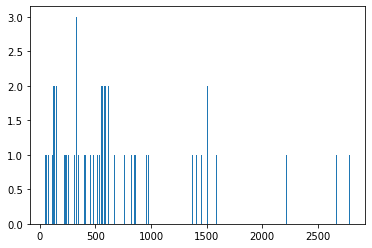

In [ ]:
# Hago un plot de la cantidad de caracteres que tiene cada review
import matplotlib.pyplot as plt
x = df['rev_content_length'] 
plt.hist(x, bins = 300)
plt.show()

In [ ]:
df[df['rev_content_length']<3]

,Unnamed: 0,imdbid,rev_title,rev_content,rating,rev_link,rev_username,rev_date,rev_content_length


No hay instancias en el df que tengan menos de 3 caracteres como texto de review.
Sin embargo, esto si que nos deja para pensar cuanto es el numero minimo de caracteres para que no los descartemos. Hay reviews de 6 caracteres (e.g. "Great!")

In [ ]:
contador_de_caracteres = df.groupby(['rev_content_length']).size()
contador_de_caracteres

rev_content_length
50      1
60      1
85      1
105     1
114     1
115     1
124     1
127     1
145     1
149     1
221     1
226     1
233     1
255     1
309     1
327     1
329     1
330     1
349     1
397     1
410     1
455     1
486     1
517     1
542     1
558     1
559     1
567     1
569     1
581     1
584     1
589     1
594     1
621     1
622     1
672     1
754     1
822     1
847     1
862     1
956     1
974     1
1371    1
1403    1
1452    1
1502    1
1506    1
1591    1
2217    1
2663    1
2788    1
dtype: int64

A partir de 50 caracteres empieza a ser mas habitual la cantidad de reviews de dicha longitud o mas

# Limpieza de datos - Text normalizer
Empiezo usando el dataset de prueba (df_prueba), que contiene 100 comentarios.

Despues, hay correr lo mismo pero con el dataset completo (df)

 * Remocion de caracteres acentuados

In [ ]:
# Funcion para remover caracteres acentuados
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

* Expansion de contracciones

In [ ]:
# Importo un dict de contracciones 
# https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
import re 
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

* Remocion de caracteres especiales

Aca saco tambien puntuaciones, parentesis, etc.
Capaz esto deberia hacerlo despues de tokenizar si no quiero perder esta informacion al hacer part of speach, etc

In [ ]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

* Lematizacion

In [ ]:
#nltk.download('wordnet')

In [ ]:
from nltk.stem import WordNetLemmatizer 
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer() 
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

* Stemming

In [ ]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

* Remocion de stopwrods

In [ ]:
# Importo tokenizador
tokenizer = ToktokTokenizer()

# Importo lista de stopwords
stopword_list = nltk.corpus.stopwords.words('english')

In [ ]:
# Aclaro que palabras no quiero que esten entre las stopwords --> pronombres
exclude_from_stopwords = ['he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
                         'herself', 'they', 'them', 'their', 'theirs', 'themselves']
for word in exclude_from_stopwords:
    stopword_list.remove(word)

In [ ]:
# Creo funcion que remueve stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

* Normalizacion el txt de las reviews segun el tipo de ingles  (US o British)

In [ ]:
def replace_all(text, mydict):
    for gb, us in mydict.items():
        text = text.replace(us, gb)
    return text

In [ ]:
# Leo el archivo txt con el diccionario US --> British
with open("C:/Users/tomas/Desktop/Maestria Data Mining/Text Mining/us2gb-dictionary.txt") as f:
  us2gb = dict(x.rstrip().split(None, 1) for x in f)

* Convertir emojis a palabras

In [ ]:
def extract_emoji(text):
    emoji.demojize(text, delimiters=("", ""))
    return text

# Preprocesamiento de los reviews

Todas las pruebas sobre df_prueba. Luego reemplazar y correrlo sobre el df general

Creo la funcion "preprocesamiento" que hace una limpieza general de las reviews.

Ademas, las tokeniza por oraciones y luego por palabras

In [ ]:
# Creo la funcion preprocesamiento a ver si me devuelve lo que quiero
def preprocesamiento(review, remove_typos=True, accented_char_removal=True,
                     contraction_expansion=True, text_lower_case=True,
                     text_stem = False, text_lemmatization=False,
                     special_char_removal=True, stopword_removal=True,
                     english_norm = True, emoji_extraction = True):
    
    ###### LIMPIEZA ######
    # Corrije errores de ortografia
    if remove_typos:
        review = str(TextBlob(review).correct())
    # Normalizacion del ingles (lleva todo a British) 
    if english_norm:
        review = replace_all(review, us2gb)
    # Convierte emojis a text
    if emoji_extraction:
        review = extract_emoji(review)
    # Remueve saltos de linea
    review = re.sub(r'[\r|\n|\r\n]+', ' ',review)
    # Remueve acentos de los caracteres
    if accented_char_removal:
        review = remove_accented_chars(review)
    # Exande las contracciones. Ej: don't --> do not 
    if contraction_expansion: 
        review = expand_contractions(review)
    # Convierte todo a minuscula
    if text_lower_case:    
        review = review.lower()
    # Remueve caracteres especiales
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        review = special_char_pattern.sub(" \\1 ", review) 
    # Remueve espacios en blanco
    review = re.sub(' +', ' ', review)
    # Remueve stopwords
    if stopword_removal:
        review = remove_stopwords(review, is_lower_case=True)
    # Lematizacion
    if text_lemmatization:
        review = lemmatize_text(review)
    # Stemming
    if text_stem:
        review = simple_stemmer(review)
        
    ###### TOKENIZACION ######        
    # Tokeniza por oracion
    oraciones_tokenizadas = sent_tokenize(review)
    # Crea lista vacia de oraciones
    oraciones = []      
        # Agrega las palabras tokenizadas a una lista de oracion.
        # Cada lista de oracion se agrega a una lista de oraciones.
    for oracion in oraciones_tokenizadas:
        oraciones.append([word for word in word_tokenize(oracion) if word.isalpha()])
    # Deuvelve la lista de oraciones
    return (oraciones)

In [ ]:
# Pruebo la funcion "preprocesamiento" con un apply lambda
df['rev_token']  = df['rev_content'].apply(lambda x: preprocesamiento(x, stopword_removal=False ))

## Normalizaciones adicionales

libreria "normalise"
https://github.com/EFord36/normalise

Ejemplos de tokens a normalizar incluyen:
-    numeros --> porcentajes, fechas, dinero
-    abreviaciones y acronimos
-    hashtags y sitios webs
-    errores de ortografia (double cheking, teniendo en cuenta que previamente el texto de las reviews ya fue limpiado de typos en la funcion "preprocesamiento")


Defino una funcion de normalizacion
1) Creo la funcion
2) input: review --> lista de listas donde cada lista es una oracion
3) creo una lista vacia --> review_output
4) para cada oracion dentro de la review:
    a) normalizo
    b) appendeo a la lista review_output

In [ ]:
# Defino una funcion que normalice cada oracion del review
def normalizacion(review):
    # input: review --> lista de listas donde cada lista es una oracion
    review_output = []
    for oracion in review:
        # Normalizo cada oracion y la appendeo a una lista
       review_output.append(normalise(oracion, verbose=False))
    # Devuelvo la lista de oraciones normalizadas
    return (review_output)

In [ ]:
# Aplico la funcion de normalizacion a la columna de reviews tokenizados
df['rev_norm_token']  = df['rev_token'].apply(lambda x: normalizacion(x))

### Armar 'collocations'

In [ ]:
# Armo el corpus completo para collocations
corpus_collocations = []
for rev in df.rev_content:
  rev = rev.lower()
  #split by sentence
  sentences = sent_tokenize(rev)
  for sent in sentences:
    # word tokenize and append the sentence as a list of words
    corpus_collocations.append([word for word in word_tokenize(sent) if word.isalpha()])

In [ ]:
collocations = Phrases(sentences=corpus_collocations , min_count=10,threshold=0.5,scoring='npmi') # threshold: minimo score aceptado

In [ ]:
to_collocations = Phraser(collocations)

In [ ]:
df_collocations =pd.DataFrame([x for x in collocations.export_phrases(corpus_collocations)],columns=["bigram","score"])
df_collocations.shape

(154, 2)

In [ ]:
df_collocations.drop_duplicates().sort_values(by="score",ascending=False).head(50)

,bigram,score
11,b'mental health',0.935302
1,b'the book',0.595617
5,b'if you',0.586535
18,b'this film',0.549967
0,b'to see',0.510140
3,b'this movie',0.508722
8,b'to be',0.505075


In [ ]:
df['rev_token_ngrams']  = df['rev_token'].apply(lambda x: to_collocations[x])
df.loc[0,'rev_token_ngrams']

In [ ]:
print("el corpus de imdb tiene", len(df['rev_token']), "reviews,",sum([len(x) for x in df['rev_token']]),"oraciones y", sum([len(y) for x in df['rev_token'] for y in x]) ,"palabras")

el corpus de imdb tiene 51 reviews, 470 oraciones y 6515 palabras


# BORRADOR:
## Tokenizacion

In [ ]:
import nltk
#nltk.download('punkt')
from nltk import word_tokenize
from nltk import sent_tokenize


In [ ]:
def custom_tokenize(text):
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    # find a word character: character from a-z, A-Z, 0-9
    return nltk.RegexpTokenizer(r'\w+').tokenize(text)
df_prueba['tokenized_rev'] = df_prueba.rev_content.apply(custom_tokenize)
df_prueba.head()


In [ ]:
tokens_prueba = df_prueba.loc[41,'tokenized_rev']
tokens_prueba

## Funcion normalizadora de texto
Reune el resto de las funciones de normalizacion construidas previamente

In [ ]:
def normalize_corpus(corpus,contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, text_stem = False,
                     text_lemmatization=False, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # stem text
        if text_stem:
            doc = simple_stemmer(doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Prueba de preprocesamiento y normalizacion de reviews

In [ ]:
df_prueba['clean_rev_content'] = normalize_corpus(df_prueba['rev_content'])
df_prueba.head()

C:\Users\tomas\Anconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,imdbid,rev_title,rev_content,rating,rev_link,rev_username,rev_date,clean_rev_content
0,0,tt3907584,A spectacular movie\n,"The first act felt annoyingly pretentious, how...",9,/review/rw5556178/,MR_Heraclius,20200316,first act felt annoyingly pretentious however ...
1,1,tt3907584,so....read this up.\n,I did not know this was made after a book. I d...,9,/review/rw5515902/,suciulaurentiucristian,20200228,know wa made book care book wa better actual c...
2,2,tt3907584,they had so much but they gave too little\n,I had this feeling since they announced the mo...,5,/review/rw5515384/,mermariam,20200228,feeling since they announced movie disappointe...
3,3,tt3907584,People who call him selfish have never experi...,I saw some negative reviews not getting the lo...,10,/review/rw5525473/,viktoriabr-21711,20200304,saw negative review getting logic him comittin...
4,4,tt3907584,Beautiful movie.\n,Randomly found this movie today and I only hav...,10,/review/rw5516559/,aeo-90520,20200229,randomly found movie today praise acting wonde...


In [ ]:
#df_prueba_corpus = list(df_prueba['clean_rev_content'])

In [ ]:
df_prueba.iloc[1][['rev_content', 'clean_rev_content']].to_dict()

{'rev_content': "I did not know this was made after a book. I don't care if the book was better. The actual capacity of a screenplay writer and a director to reproduce the book can and will be forever disputed.\nWhat i want to say is that this movie takes you place. You laugh. You care. You love and You cry. This movie has emotion and has life. You, for the time it runs, feel.Is not this the purpose of a movie? To make you feel? to connect to the characters - their joy, their sorrow?\nThis aside - the acting ,the music, the photography....everything is so well suited to the scenario and the purpose of the movie. To feel. Not to understand but to feel.\nWatch it to live true emotions. Do not if you dont.\nFor what was this movie made, it's a jewel. Take it as it is.",
 'clean_rev_content': 'know wa made book care book wa better actual capacity screenplay writer director reproduce book forever disputed want say movie take place laugh care love cry movie ha emotion ha life time runs feel 

# Links utiles  
    - Spelling correction --> http://norvig.com/spell-correct.html
    - Mejorar lematizacion con text blob --> https://textblob.readthedocs.io/en/dev/quickstart.html
    
    - https://github.com/vaishalilambe/NLP-Basics--Data-Cleaning-Pipeline/blob/master/NLPBasics.ipynb
    - https://medium.com/@dobko_m/nlp-text-data-cleaning-and-preprocessing-ea3ffe0406c1
    - https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0
    - https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a : Punctuation removal is better to be done after the tokenization step, doing it before might cause undesirable effects.
  